In [1]:
import cv2
import h5py
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

Fontconfig warning: ignoring UTF-8: not a valid region tag


In [2]:
class FootballDataset(Dataset):
    def __init__(self, filename, scaleShape=None):
        self.filename = filename
        self.h5file = None
        self.len = 0
        self._assertOpen()
        self.info = {}
        self.labels = None
        self.scaleShape = scaleShape

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        self._assertOpen()

        image, label = self._loadRaw(idx)
        return image, label

    def _assertOpen(self):
        if (self.h5file is None):
            self.h5file = h5py.File(self.filename, mode="r")
            groupImages = self.h5file["images"]
            self.len = len(groupImages)
            self.info = json.loads(bytes(self.h5file.get("info")))
            self.labels = self.h5file.get("labels")


    def _loadRaw(self, idx):
        groupImages = self.h5file["images"]
        # Loadneme image
        bImage = groupImages.get(str(idx))
        image = cv2.imdecode(np.array(bImage), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if (self.scaleShape is not None):
            image = cv2.resize(image, self.scaleShape, interpolation=cv2.INTER_AREA)

        dist = np.array(self.h5file["labels"][idx])
        return image, dist


In [3]:
def showImage(x, h=9):
    fig = plt.figure(figsize=(h*16.0/9.0,h))
    plt.axis("off")
    plt.imshow(x)
    plt.show()
    plt.close()

#------------------------------------------------------------------------------
#   Eval Utils

def rescale(image, scaleShape=(640,360)):
    return cv2.resize(image, scaleShape)

def buildMaps(size, k):
    h, w = size
    cx = w/2.0
    cy = h/2.0

    # Ideme zlozit mapy
    x = (np.linspace(0, w+1, w) - cx) / h
    y = (np.linspace(0, h+1, h) - cy) / h
    xx,yy = np.meshgrid(x, y)
    rr = np.sqrt(xx**2 + yy**2)

    # Nascitavame mocniny koeficientov
    d = np.ones_like(rr)
    for i,kk in enumerate(k):
        d += kk * (rr ** (2 * (i+1)))

    mapX = (d*xx*h + cx).astype(np.float32)
    mapY = (d*yy*h + cy).astype(np.float32)
    return mapX, mapY

def undistort(image: np.ndarray, k:np.ndarray, scaleShape=(640, 360)):
    image = rescale(image, scaleShape)

    # Pouzivame skalovaci faktor -> H ~ 1.0
    w, h = image.shape[1], image.shape[0]

    # Create undistort maps
    k1 = k[0]
    if (k.shape[0] > 1):
        k2 = k[1]
    else:
        k2 = 0.019*k1 + 0.805*(k1 ** 2)
    kk = [k1, k2]

    map1, map2 = buildMaps((h,w), kk)

    # Undistort image
    result = cv2.remap(image, map1, map2, cv2.INTER_LINEAR)
    return result

def merge(x1, x2):
    H,W,C = x1.shape
    result = np.zeros(shape=(H,W*2,C), dtype=x1.dtype)
    result[:,0:W,:] = x1
    result[:,W:2*W,:] = x2
    return result

def displayAndFix(x, dc, scaleShape=(640, 360), h=9):
    xOriginal = rescale(x, scaleShape)
    xFix = undistort(x, dc, scaleShape=scaleShape)
    xMerge = merge(xOriginal, xFix)
    showImage(xMerge, h=h)


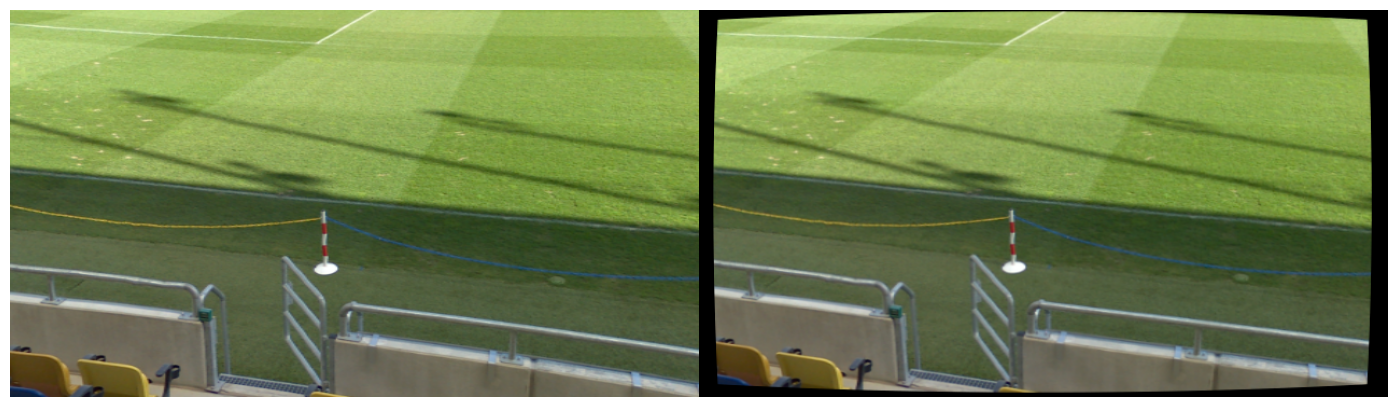

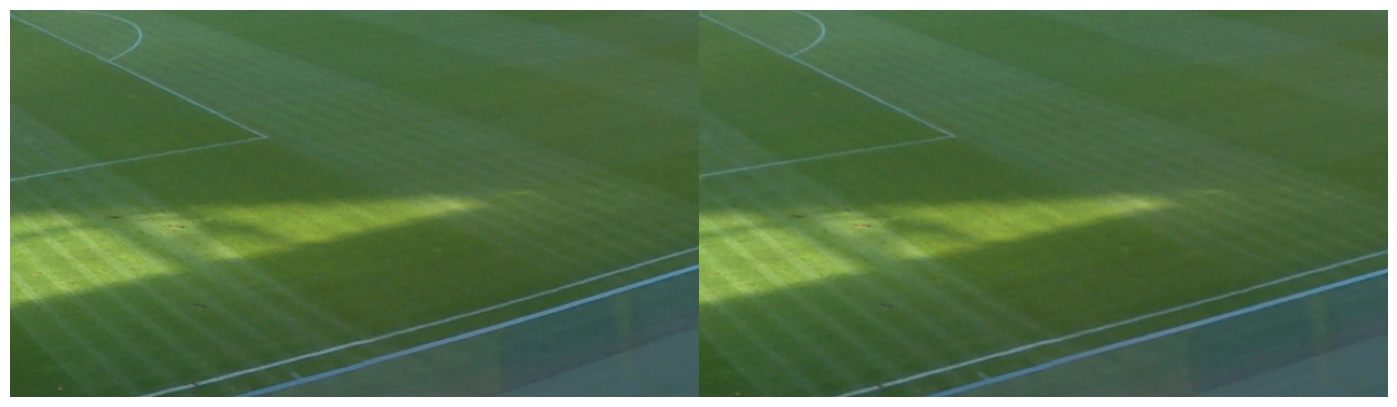

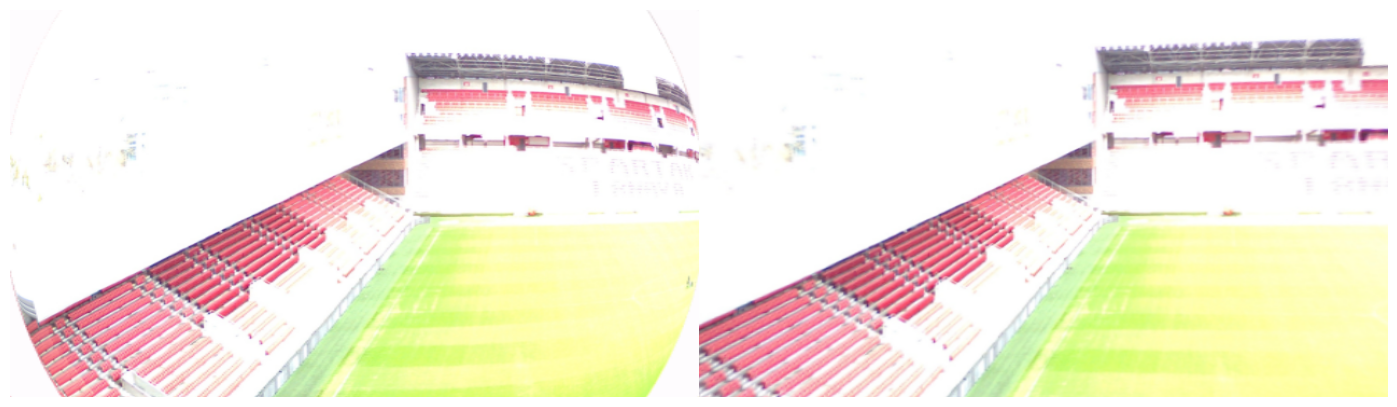

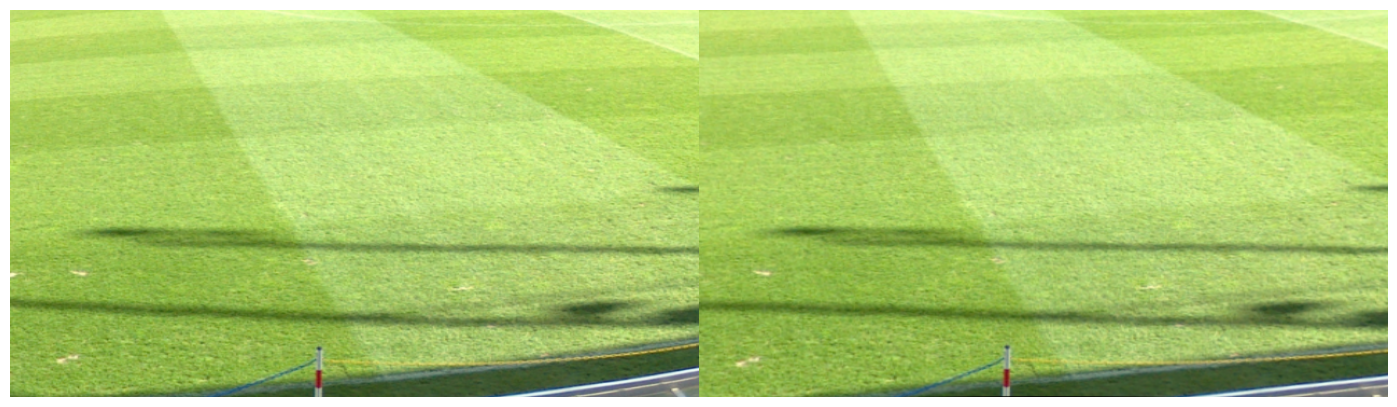

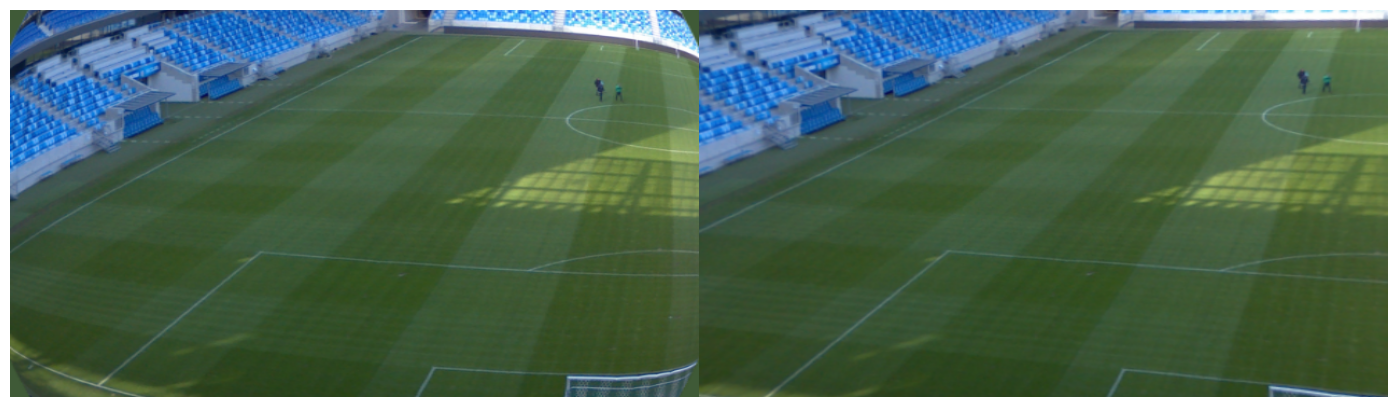

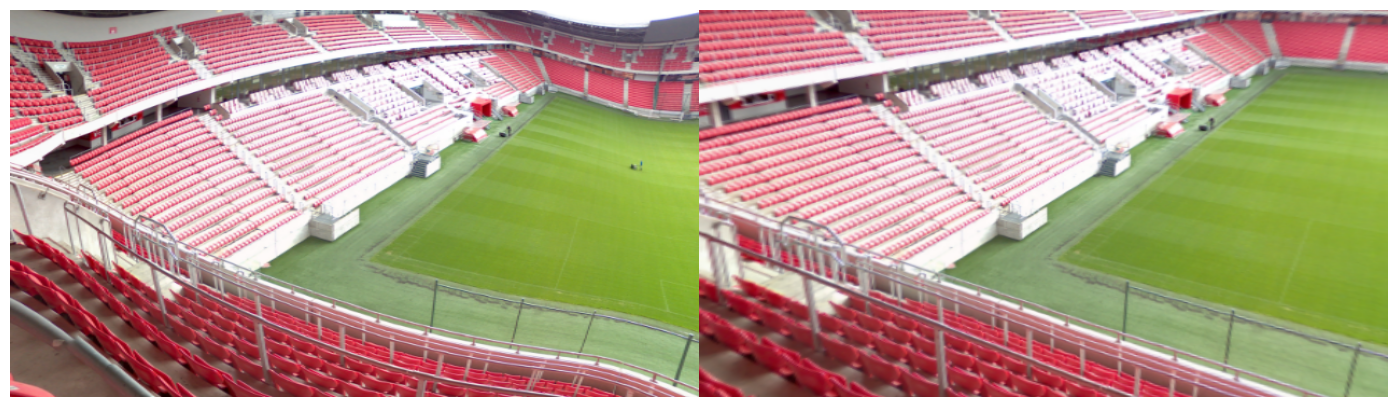

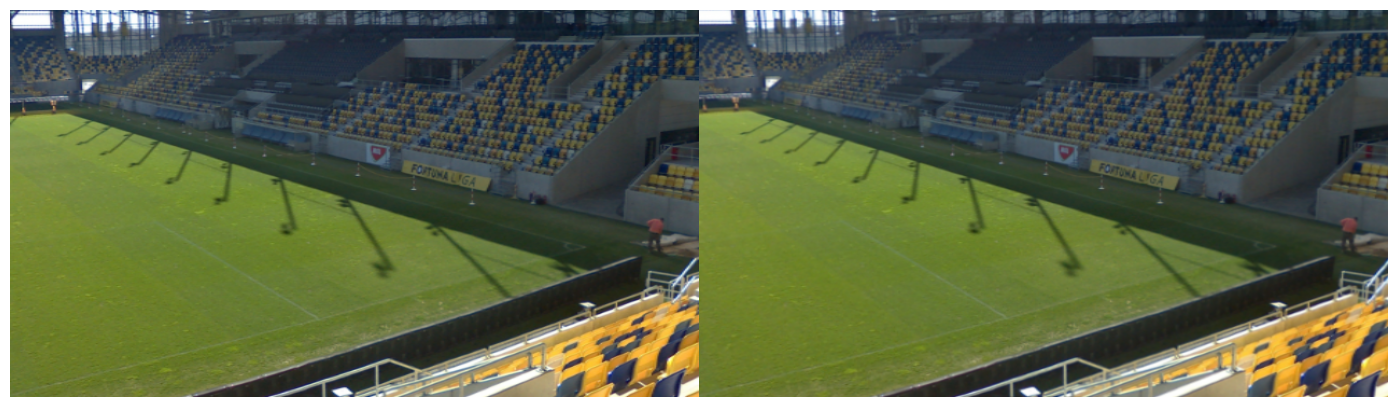

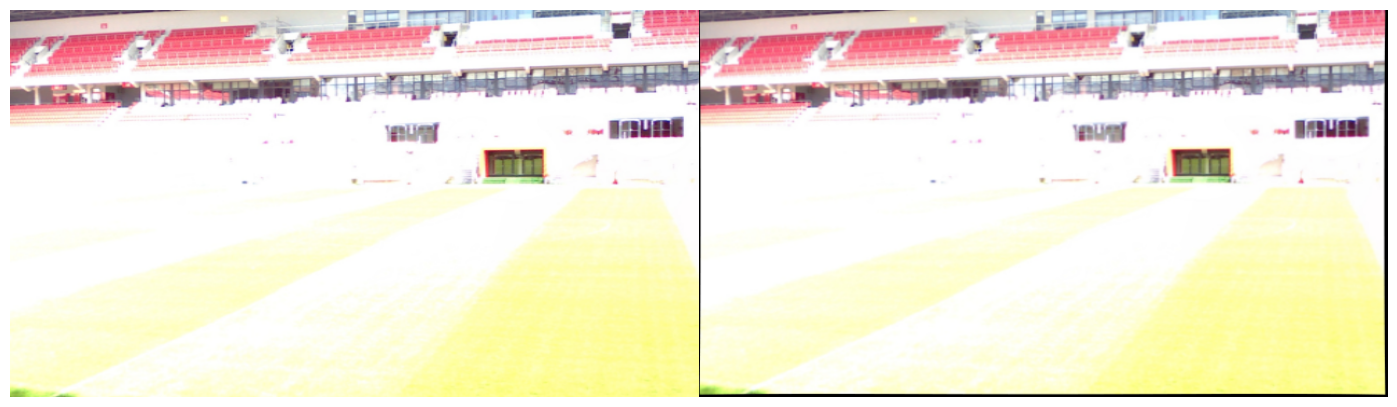

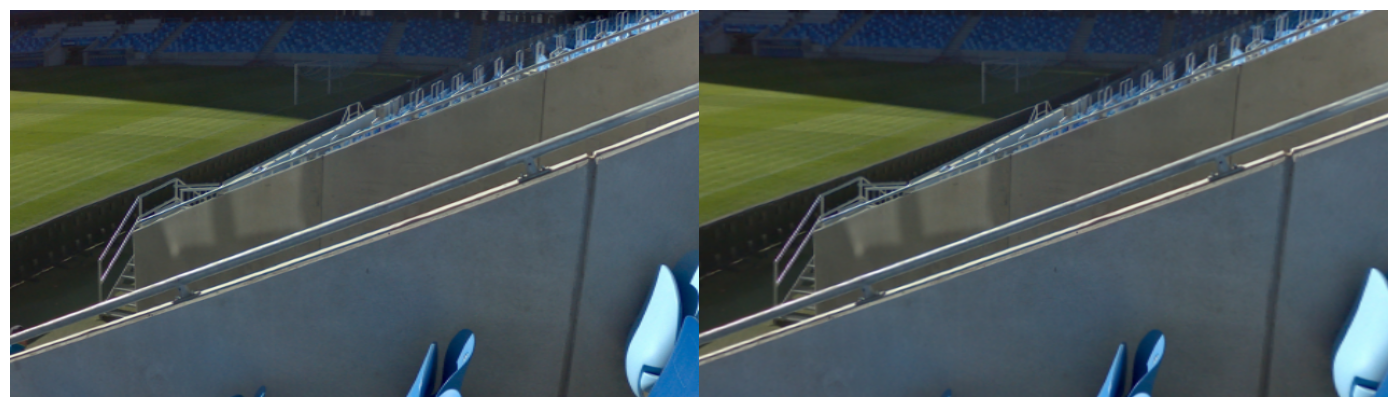

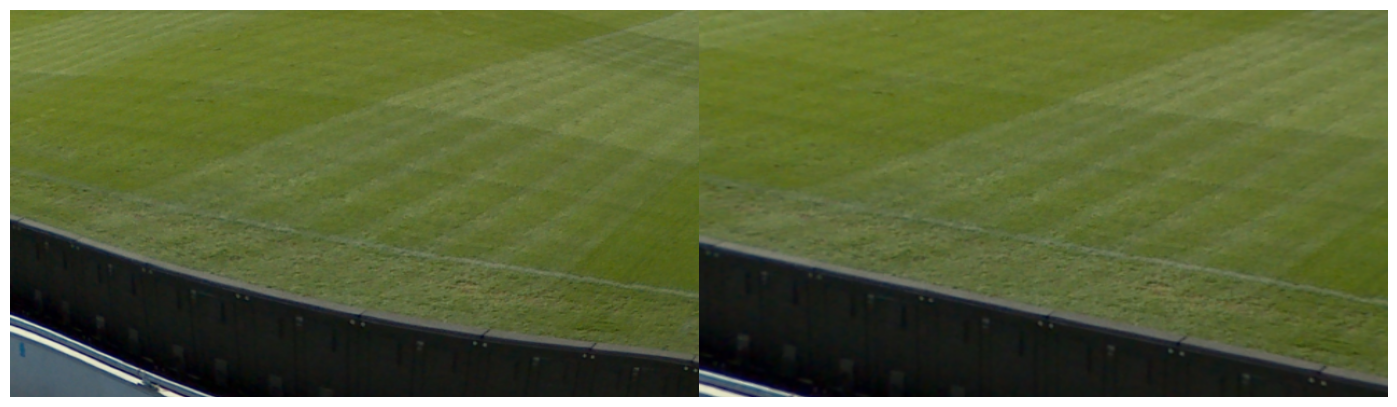

In [4]:
ds = FootballDataset("../run/val.h5")
idx = np.random.choice(len(ds), 10, replace=False)
for i in idx:
    img, label = ds[i]
    displayAndFix(img, label, h=10)
